# Automation of Human Karyotype Analysis Using Image Segmentation and Classification Methods. Segmentation.

## Data and imports

In [ ]:
!gdown 1LtQZ_9ofcJfSwmEuzXHnAJrgGyDab_Xw

Downloading...
From (original): https://drive.google.com/uc?id=1LtQZ_9ofcJfSwmEuzXHnAJrgGyDab_Xw
From (redirected): https://drive.google.com/uc?id=1LtQZ_9ofcJfSwmEuzXHnAJrgGyDab_Xw&confirm=t&uuid=ab6bd4a6-db60-4097-98e2-412cf818d1f3
To: /content/Data.zip
100% 1.04G/1.04G [00:07<00:00, 144MB/s]


In [ ]:
!unzip /content/Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: 24_chromosomes_object/annotations/1080893.xml  
  inflating: 24_chromosomes_object/annotations/1080894.xml  
  inflating: 24_chromosomes_object/annotations/1080902.xml  
  inflating: 24_chromosomes_object/annotations/1080903.xml  
  inflating: 24_chromosomes_object/annotations/1080904.xml  
  inflating: 24_chromosomes_object/annotations/1080911.xml  
  inflating: 24_chromosomes_object/annotations/1080914.xml  
  inflating: 24_chromosomes_object/annotations/1080921.xml  
  inflating: 24_chromosomes_object/annotations/1080922.xml  
  inflating: 24_chromosomes_object/annotations/1080923.xml  
  inflating: 24_chromosomes_object/annotations/1080924.xml  
  inflating: 24_chromosomes_object/annotations/1080931.xml  
  inflating: 24_chromosomes_object/annotations/1080933.xml  
  inflating: 24_chromosomes_object/annotations/1080934.xml  
  inflating: 24_chromosomes_object/annotations/1080941.xml  
  inflating: 24_chromosomes_object

In [ ]:
!rm -f /content/*.txt
!rm -f /content/*.csv
!rm -rf /content/weight

In [ ]:
!pip install ultralytics
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import os
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
import cv2
from ultralytics import YOLO
import glob
import random
import shutil
import numpy as np
from torchvision import transforms, models, ops
from torchvision.ops import box_iou

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Faster R-CNN and Retinanet

In [ ]:
def load_dataset(images_dir, annotations_dir):
    """Load dataset"""
    dataset = []
    image_files = sorted(os.listdir(images_dir))
    for image_filename in image_files:
        if image_filename == "103064.jpg" or image_filename == "1050431.jpg":
            continue

        image_path = os.path.join(images_dir, image_filename)
        image = Image.open(image_path).convert("RGB")

        annotation_filename = os.path.splitext(image_filename)[0] + '.xml'
        annotation_path = os.path.join(annotations_dir, annotation_filename)
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            labels.append(1)
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        image = F.to_tensor(image)

        dataset.append((image, target))
    return dataset

def get_fasterrcnn_model(num_classes, pretrained):
    """Returns Faster R-CNN model for further training"""
    if pretrained:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    else:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def get_retinanet_model(num_classes, pretrained):
    """Return RetinaNet for further training"""
    if pretrained:
        model = torchvision.models.detection.retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)
    else:
        model = torchvision.models.detection.retinanet_resnet50_fpn(weights=None)

    in_features = model.head.classification_head.conv[0][0].in_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = RetinaNetClassificationHead(in_features, num_anchors, num_classes)
    return model

def train_one_epoch(model, optimizer, data_loader, device):
    """Training of one epoch, returns loss"""
    model.train()
    running_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        running_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return running_loss / len(data_loader)

def evaluate(model, data_loader, device):
    """Evaluation function, calculates MeanAveragePrecision() metrics"""
    metric = MeanAveragePrecision()
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            outputs = [{k: v.cpu() for k, v in out.items()} for out in outputs]
            targets = [{k: v.cpu() for k, v in t.items()} for t in targets]
            metric.update(outputs, targets)
    metric = metric.compute()
    return metric

def evaluate_f1(model, data_loader, device, iou_threshold=0.5):
    """Calculates F1 scores across 10 confidence thresholds"""
    conf_thresholds = np.linspace(0.0, 1.0, 11)

    model.eval()
    f1_scores = []

    with torch.no_grad():
        for conf_th in conf_thresholds:
            tp = 0
            fp = 0
            fn = 0

            for images, targets in data_loader:
                images = [img.to(device) for img in images]
                outputs = model(images)
                outputs = [{k: v.cpu() for k, v in o.items()} for o in outputs]

                for output, target in zip(outputs, targets):
                    keep = output['scores'] >= conf_th
                    pred_boxes = output['boxes'][keep]
                    gt_boxes = target['boxes']

                    if len(pred_boxes) == 0:
                        fn += len(gt_boxes)
                        continue
                    if len(gt_boxes) == 0:
                        fp += len(pred_boxes)
                        continue

                    ious = box_iou(pred_boxes, gt_boxes)
                    matched_pred = torch.zeros(len(pred_boxes), dtype=torch.bool)
                    matched_gt = torch.zeros(len(gt_boxes), dtype=torch.bool)

                    for i in range(len(pred_boxes)):
                        j = torch.argmax(ious[i])
                        if ious[i, j] >= iou_threshold and not matched_gt[j]:
                            matched_pred[i] = True
                            matched_gt[j] = True

                    tp += matched_pred.sum().item()
                    fp += (~matched_pred).sum().item()
                    fn += (~matched_gt).sum().item()

            precision = tp / (tp + fp) if tp + fp > 0 else 0.0
            recall = tp / (tp + fn) if tp + fn > 0 else 0.0
            f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0
            f1_scores.append(f1)

    f1_scores = np.array(f1_scores)
    best_idx  = f1_scores.argmax()
    best_conf = conf_thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    return conf_thresholds, f1_scores, best_conf, best_f1

Functions for plots

In [ ]:
def inference_check(model, dataset, device, index=0, score_threshold=0.5):
    """Inference check of the model"""
    model.eval()
    image, target = dataset[index]
    image_tensor = image.to(device)

    with torch.no_grad():
        output = model([image_tensor])[0]

    image_np = image.mul(255).permute(1, 2, 0).cpu().numpy().astype("uint8")

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(image_np)
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box.cpu().numpy()
        gt_rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='g', facecolor='none'
        )
        axes[1].add_patch(gt_rect)
    axes[1].set_title("Ground Truth Boxes")
    axes[1].axis("off")

    axes[2].imshow(image_np)
    for box, score in zip(output['boxes'], output['scores']):
        if score > score_threshold:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            pred_rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            axes[2].add_patch(pred_rect)
    axes[2].set_title("Predicted Boxes")
    axes[2].axis("off")

    plt.show()

def plot_history(history, conf_thresholds, f1_scores, best_conf, best_f1):
    """Plot history of training"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(history['train_loss'])
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')

    axes[0, 1].plot(conf_thresholds, f1_scores, lw=2, color='blue')
    axes[0, 1].scatter(best_conf, best_f1, color='red', zorder=5)
    axes[0, 1].text(best_conf, best_f1, f'{best_f1:.2f} at {best_conf:.2f}', va='bottom', ha='right')
    axes[0, 1].set_title('F1 confidence curve at IoU=0.5')
    axes[0, 1].set_xlabel('Confidence')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].legend()

    axes[1, 0].plot(history['map_50'])
    axes[1, 0].set_title('mAP@50 over Epochs')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('mAP@50')

    axes[1, 1].plot(history['map'])
    axes[1, 1].set_title('mAP@50-95 over Epochs')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('mAP@50-95')

    plt.tight_layout()
    plt.show()

In [ ]:
def training_validation(model_func, model_name, pretrained, data_loader):
    """Main function for training models"""
    history = {'train_loss': []}

    print(f"\n=== Training {model_name} ===")
    model = model_func(num_classes, pretrained)
    model.to(device)

    if pretrained:
        lr=0.005
    else:
        lr=0.001

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    for epoch in range(num_epochs):
        loss = train_one_epoch(model, optimizer, train_loader, device)
        history['train_loss'].append(loss)

        metrics = evaluate(model, data_loader, device)
        for k, v in metrics.items():
            history.setdefault(k, []).append(v.item())

        print(f"Epoch {epoch+1}/{num_epochs} — loss: {loss:.4f}, "
              f"mAP@50 = {metrics['map_50']:.4f}, mAP@75 = {metrics['map_75']:.4f}, mAP@50-95 = {metrics['map']:.4f}")

        print("--------------------------------------------")

    conf_thresholds, f1_scores, best_conf, best_f1 = evaluate_f1(model, data_loader, device, iou_threshold=0.5)

    inference_check(model, full_dataset, device, index=0, score_threshold=0.5)

    torch.save(model.state_dict(), f"{model_name}.pth")

    return history, conf_thresholds, f1_scores, best_conf, best_f1

In [ ]:
images_dir = "/content/single_chromosomes_object/JEPG"
annotations_dir = "/content/single_chromosomes_object/anntations"

full_dataset = load_dataset(images_dir, annotations_dir)

indices = list(range(len(full_dataset)))
split = int(0.8 * len(full_dataset))
train_dataset = [full_dataset[i] for i in indices[:split]]
val_dataset = [full_dataset[i] for i in indices[split:]]

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 2
num_epochs = 10


=== Training Faster R-CNN (pretrained) ===


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 205MB/s]


Epoch 1/10 — loss: 0.6590, mAP@50 = 0.9588, mAP@75 = 0.7198, mAP@50-95 = 0.6146
--------------------------------------------
Epoch 2/10 — loss: 0.5140, mAP@50 = 0.9474, mAP@75 = 0.5129, mAP@50-95 = 0.5201
--------------------------------------------
Epoch 3/10 — loss: 0.4774, mAP@50 = 0.9524, mAP@75 = 0.6276, mAP@50-95 = 0.5746
--------------------------------------------
Epoch 4/10 — loss: 0.4503, mAP@50 = 0.9514, mAP@75 = 0.6193, mAP@50-95 = 0.5786
--------------------------------------------
Epoch 5/10 — loss: 0.4289, mAP@50 = 0.9616, mAP@75 = 0.6101, mAP@50-95 = 0.5704
--------------------------------------------
Epoch 6/10 — loss: 0.4132, mAP@50 = 0.9543, mAP@75 = 0.6711, mAP@50-95 = 0.5996
--------------------------------------------
Epoch 7/10 — loss: 0.3993, mAP@50 = 0.9524, mAP@75 = 0.5911, mAP@50-95 = 0.5556
--------------------------------------------
Epoch 8/10 — loss: 0.3928, mAP@50 = 0.9643, mAP@75 = 0.7375, mAP@50-95 = 0.6302
--------------------------------------------


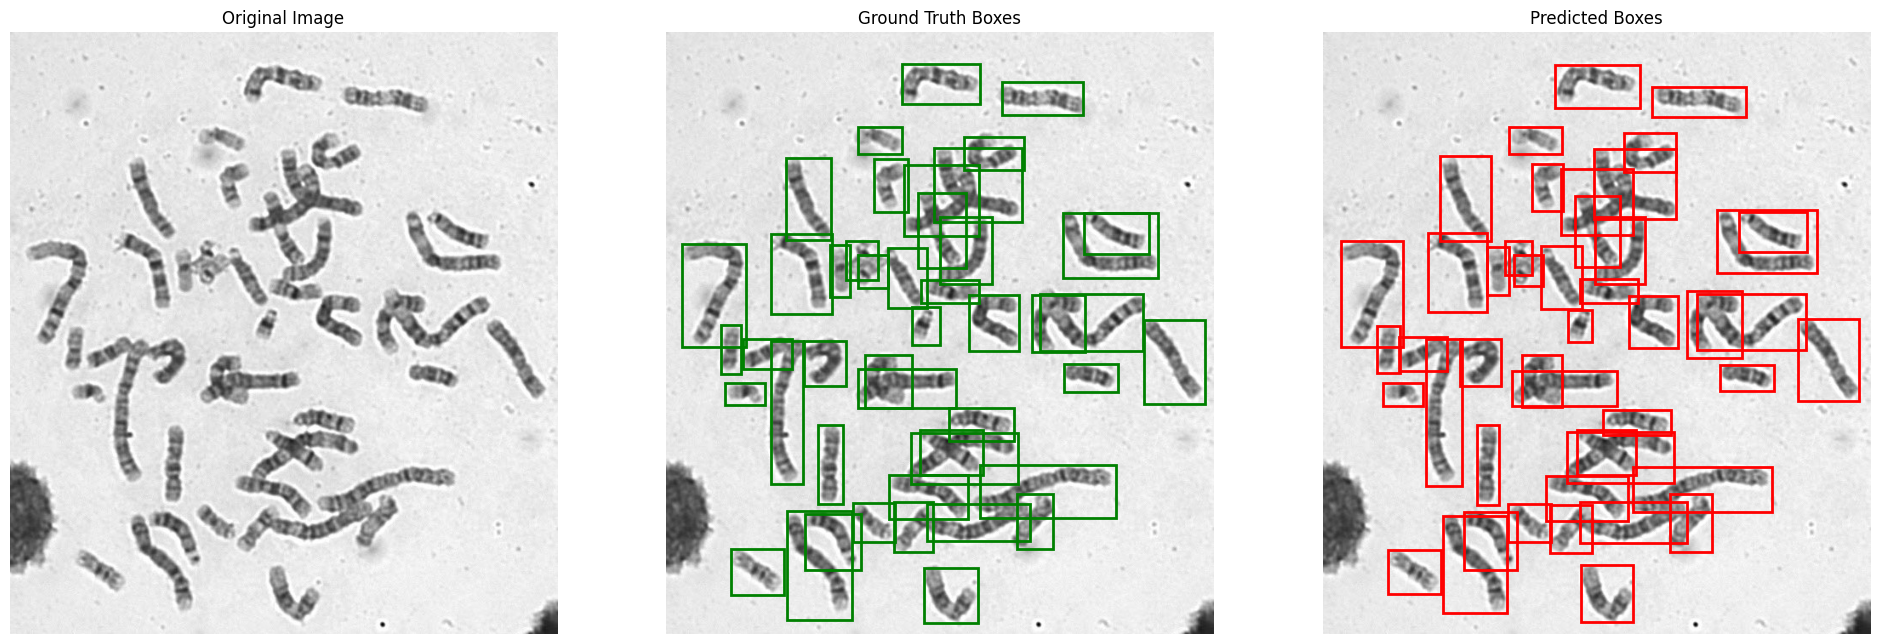

<ipython-input-7-63d9c08f82f2>:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


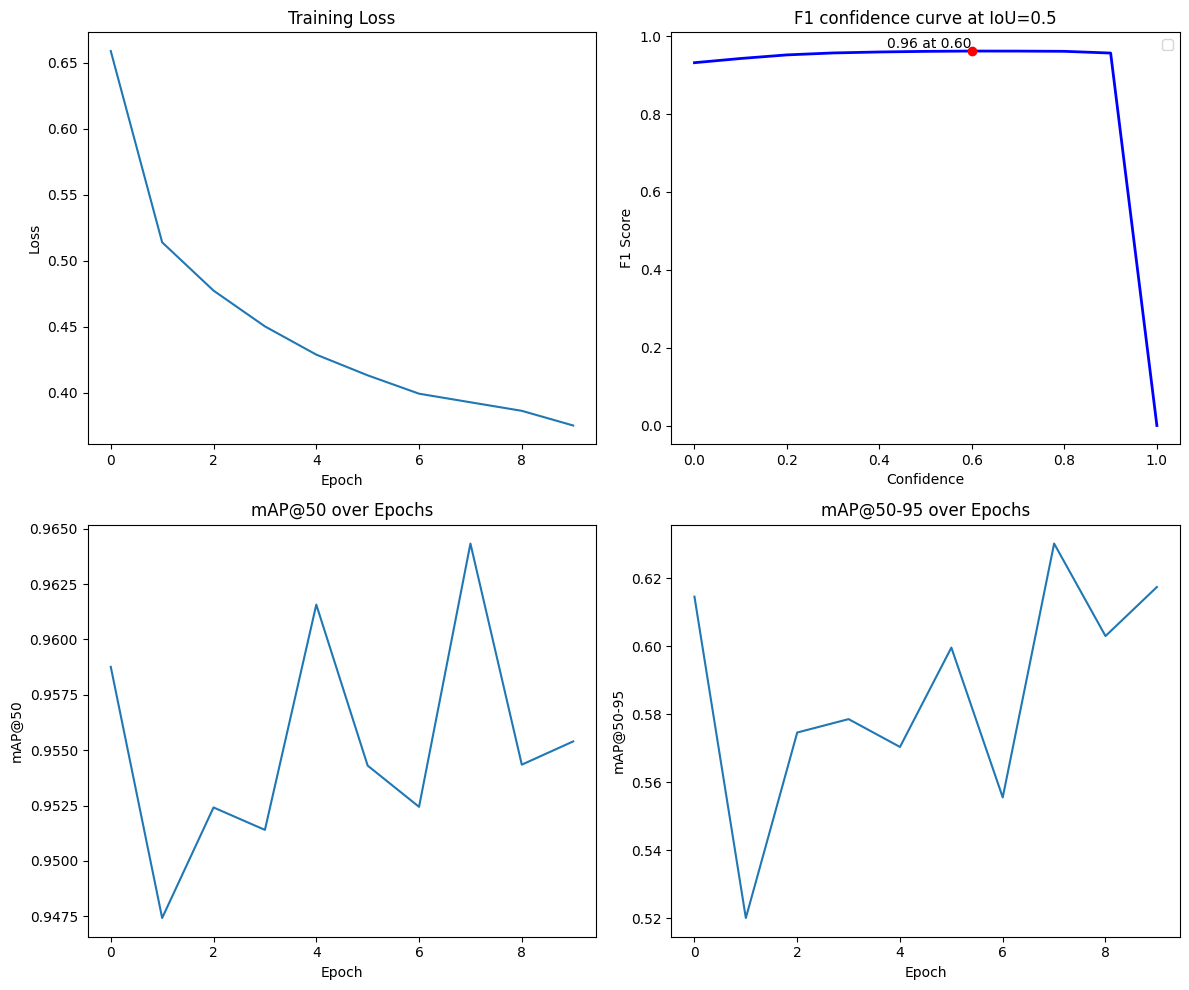

In [ ]:
history, conf_thresholds, f1_scores, best_conf, best_f1 = training_validation(get_fasterrcnn_model, "Faster R-CNN (pretrained)", True, val_loader)
plot_history(history, conf_thresholds, f1_scores, best_conf, best_f1)


=== Training Faster R-CNN (not pretrained) ===


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


Epoch 1/10 — loss: 1.4534, mAP@50 = 0.7559, mAP@75 = 0.1219, mAP@50-95 = 0.2787
--------------------------------------------
Epoch 2/10 — loss: 1.0076, mAP@50 = 0.8972, mAP@75 = 0.4189, mAP@50-95 = 0.4626
--------------------------------------------
Epoch 3/10 — loss: 0.8637, mAP@50 = 0.9177, mAP@75 = 0.5460, mAP@50-95 = 0.5194
--------------------------------------------
Epoch 4/10 — loss: 0.7794, mAP@50 = 0.9212, mAP@75 = 0.5293, mAP@50-95 = 0.5228
--------------------------------------------
Epoch 5/10 — loss: 0.7273, mAP@50 = 0.9336, mAP@75 = 0.5720, mAP@50-95 = 0.5436
--------------------------------------------
Epoch 6/10 — loss: 0.6937, mAP@50 = 0.9409, mAP@75 = 0.4871, mAP@50-95 = 0.5102
--------------------------------------------
Epoch 7/10 — loss: 0.6620, mAP@50 = 0.9469, mAP@75 = 0.6442, mAP@50-95 = 0.5724
--------------------------------------------
Epoch 8/10 — loss: 0.6417, mAP@50 = 0.9386, mAP@75 = 0.5796, mAP@50-95 = 0.5525
--------------------------------------------


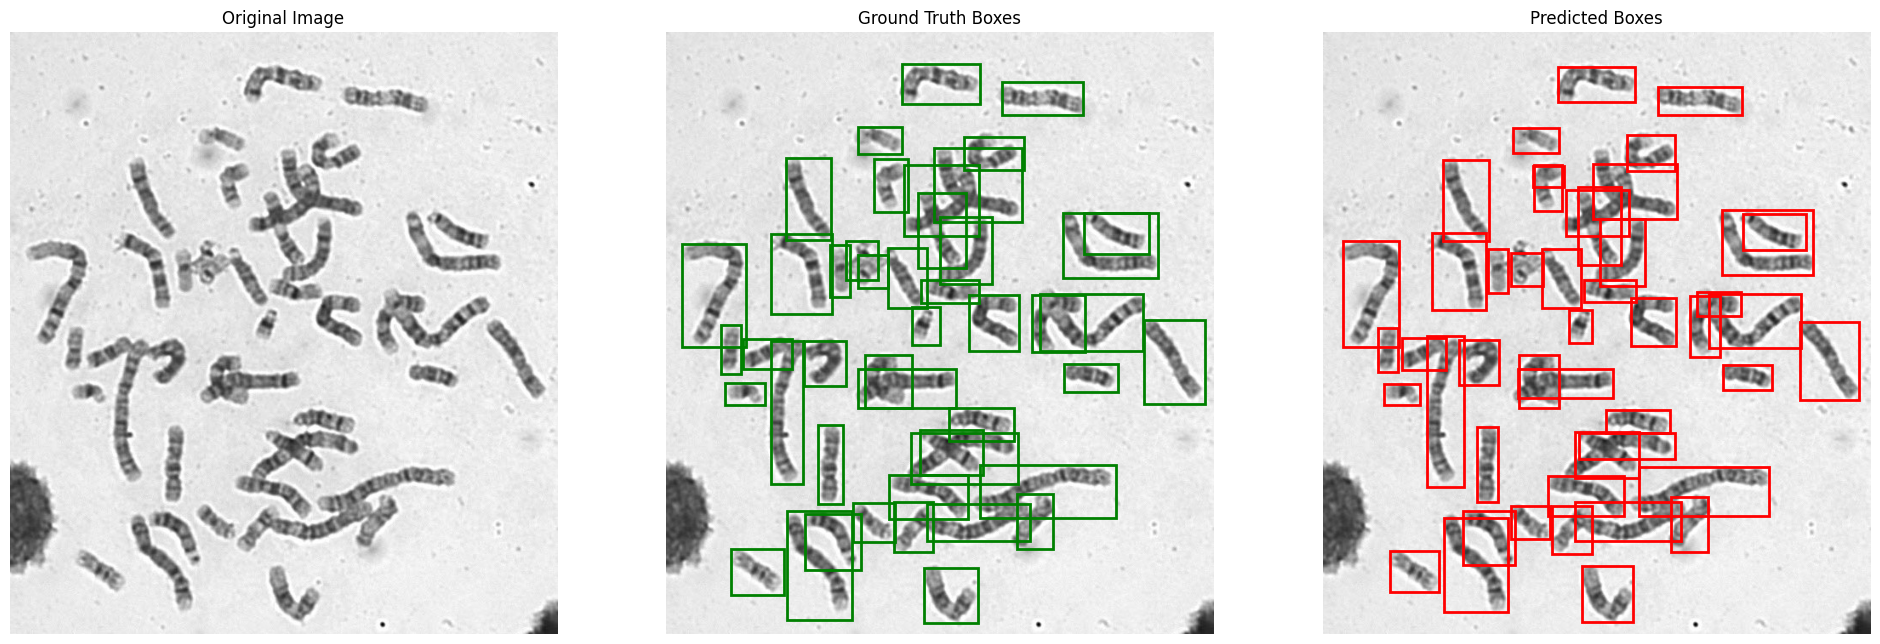

<ipython-input-7-63d9c08f82f2>:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


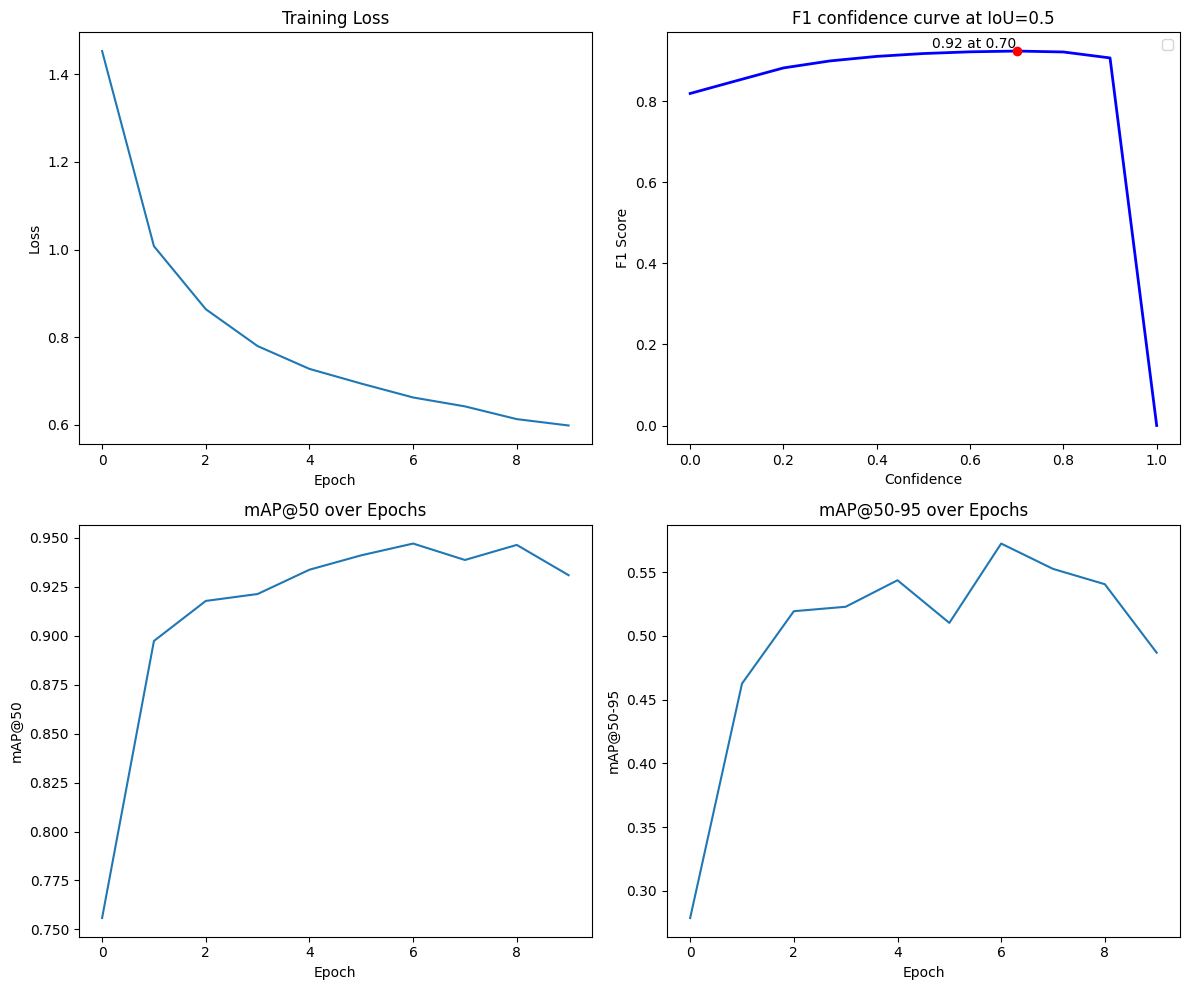

In [ ]:
history, conf_thresholds, f1_scores, best_conf, best_f1 = training_validation(get_fasterrcnn_model, "Faster R-CNN (not pretrained)", False, val_loader)
plot_history(history, conf_thresholds, f1_scores, best_conf, best_f1)


=== Training RetinaNet (pretrained) ===


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 191MB/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoch 1/10 — loss: 0.9967, mAP@50 = 0.8434, mAP@75 = 0.4353, mAP@50-95 = 0.4531
--------------------------------------------
Epoch 2/10 — loss: 0.3587, mAP@50 = 0.9267, mAP@75 = 0.5546, mAP@50-95 = 0.5400
--------------------------------------------
Epoch 3/10 — loss: 0.2904, mAP@50 = 0.9467, mAP@75 = 0.6021, mAP@50-95 = 0.5698
--------------------------------------------
Epoch 4/10 — loss: 0.2696, mAP@50 = 0.9402, mAP@75 = 0.5606, mAP@50-95 = 0.5474
--------------------------------------------
Epoch 5/10 — loss: 0.2557, mAP@50 = 0.9532, mAP@75 = 0.6107, mAP@50-95 = 0.5775
--------------------------------------------
Epoch 6/10 — loss: 0.2465, mAP@50 = 0.9517, mAP@75 = 0.6046, mAP@50-95 = 0.5738
--------------------------------------------
Epoch 7/10 — loss: 0.2385, mAP@50 = 0.9441, mAP@75 = 0.5851, mAP@50-95 = 0.5602
--------------------------------------------
Epoch 8/10 — loss: 0.2311, mAP@50 = 0.9399, mAP@75 = 0.5053, mAP@50-95 = 0.5197
--------------------------------------------


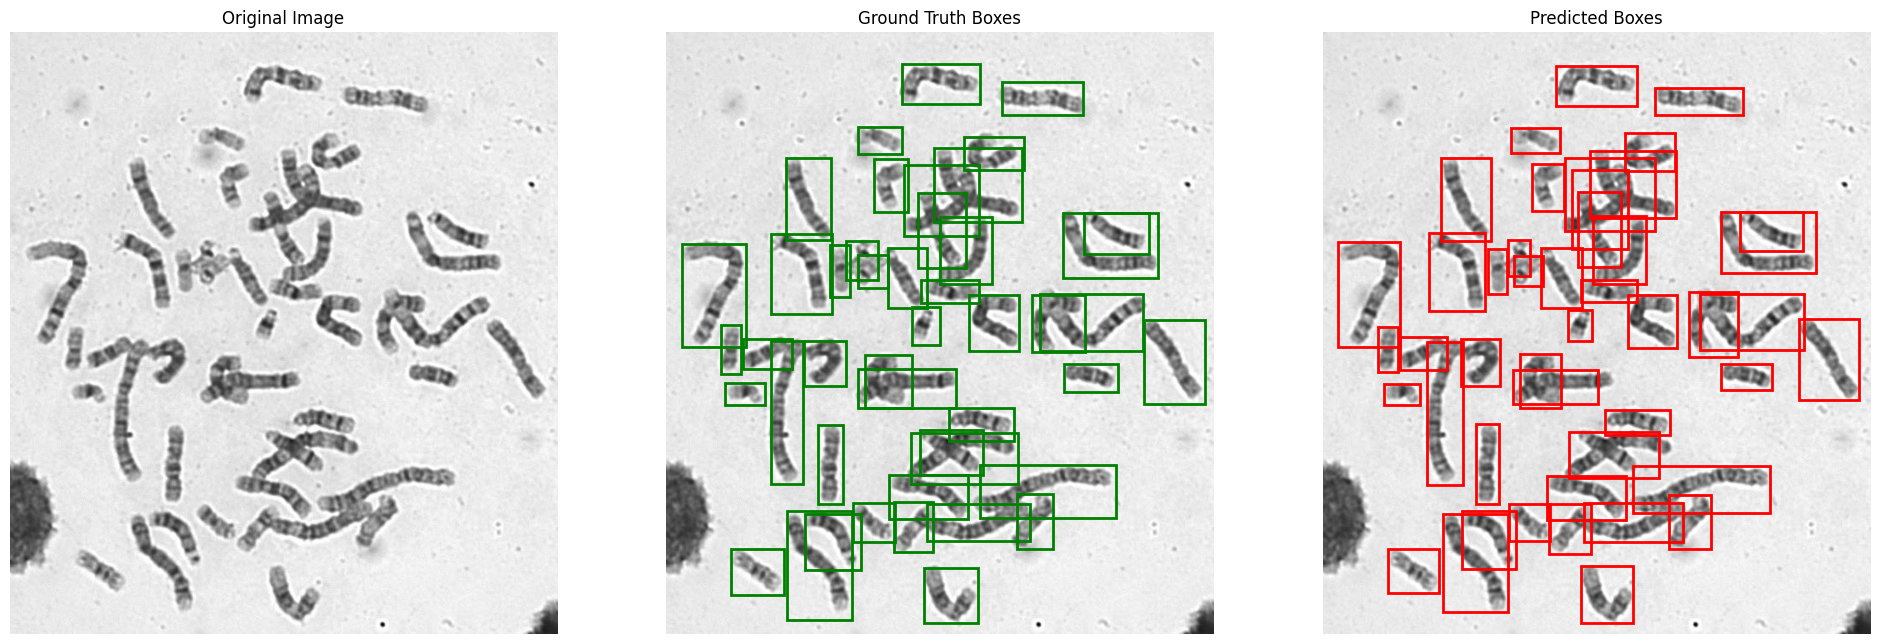

<ipython-input-7-63d9c08f82f2>:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


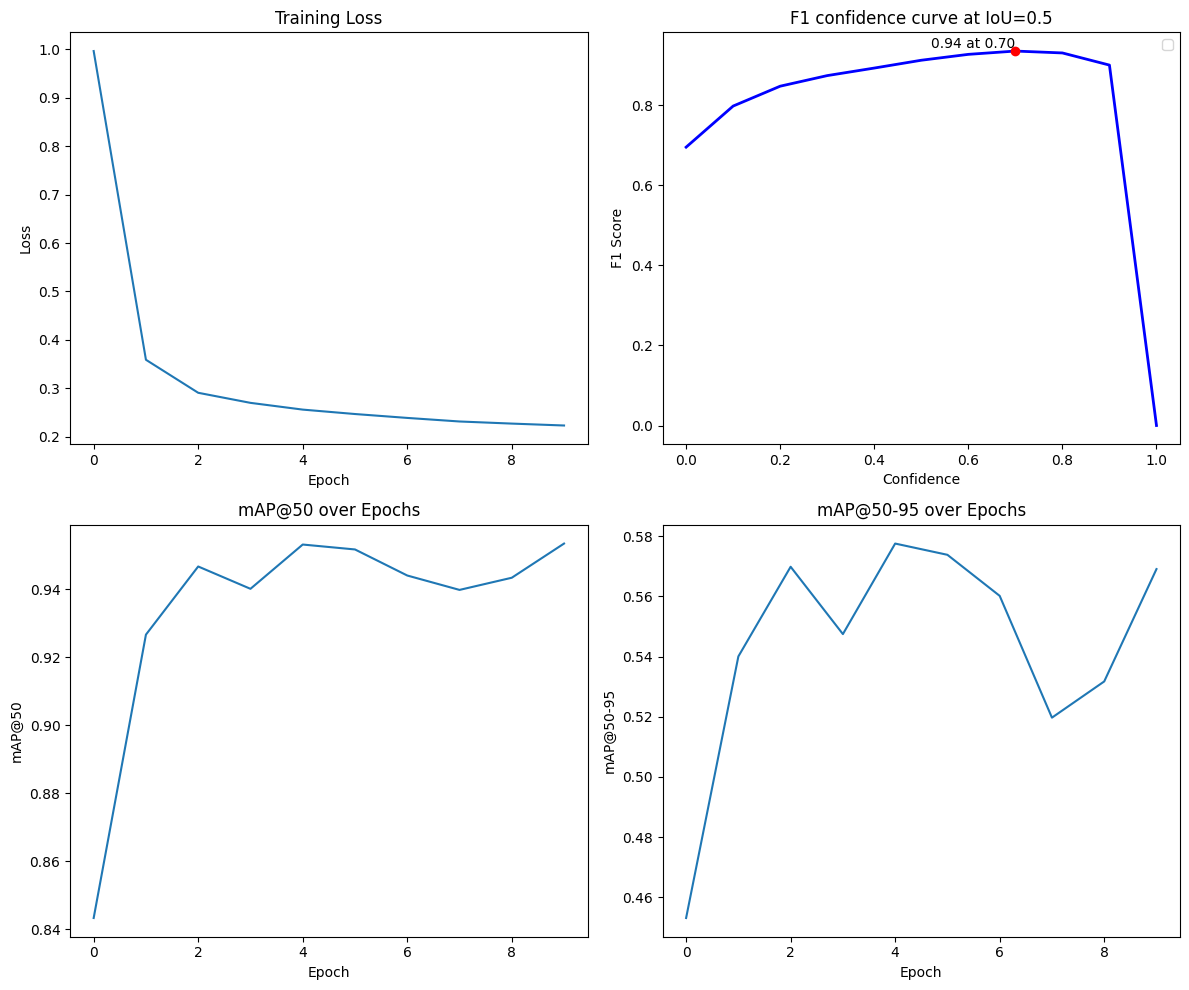

In [ ]:
history, conf_thresholds, f1_scores, best_conf, best_f1 = training_validation(get_retinanet_model, "RetinaNet (pretrained)", True, val_loader)
plot_history(history, conf_thresholds, f1_scores, best_conf, best_f1)


=== Training RetinaNet (not pretrained) ===
Epoch 1/10 — loss: 1.1910, mAP@50 = 0.3995, mAP@75 = 0.0276, mAP@50-95 = 0.1160
--------------------------------------------
Epoch 2/10 — loss: 0.6498, mAP@50 = 0.7610, mAP@75 = 0.2015, mAP@50-95 = 0.3141
--------------------------------------------
Epoch 3/10 — loss: 0.5197, mAP@50 = 0.8064, mAP@75 = 0.1614, mAP@50-95 = 0.3126
--------------------------------------------
Epoch 4/10 — loss: 0.4606, mAP@50 = 0.8780, mAP@75 = 0.3693, mAP@50-95 = 0.4323
--------------------------------------------
Epoch 5/10 — loss: 0.4320, mAP@50 = 0.8924, mAP@75 = 0.3727, mAP@50-95 = 0.4379
--------------------------------------------
Epoch 6/10 — loss: 0.4073, mAP@50 = 0.9008, mAP@75 = 0.4079, mAP@50-95 = 0.4593
--------------------------------------------
Epoch 7/10 — loss: 0.3913, mAP@50 = 0.9156, mAP@75 = 0.4752, mAP@50-95 = 0.4918
--------------------------------------------
Epoch 8/10 — loss: 0.3762, mAP@50 = 0.9200, mAP@75 = 0.4658, mAP@50-95 = 0.4912


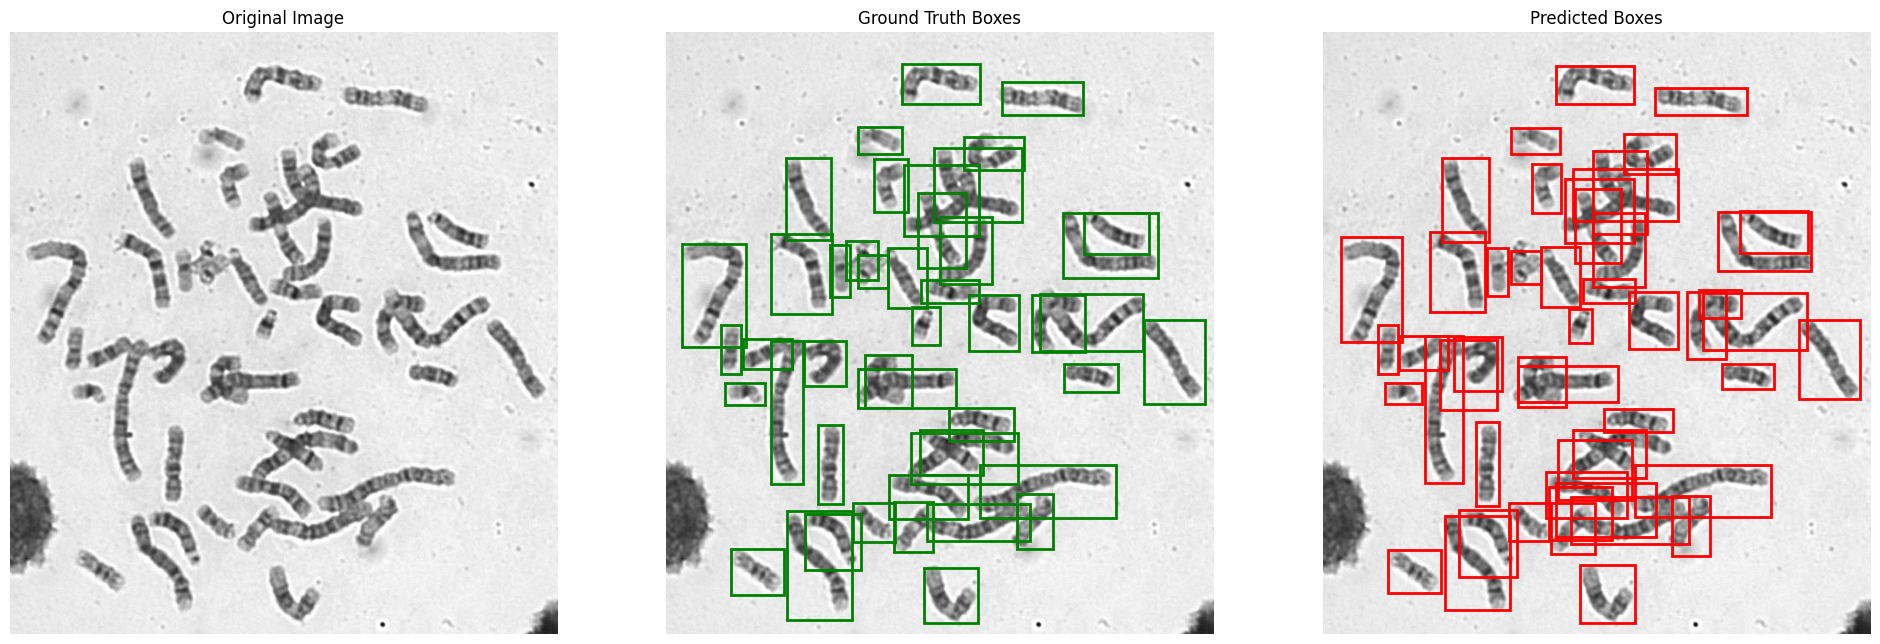

<ipython-input-7-63d9c08f82f2>:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


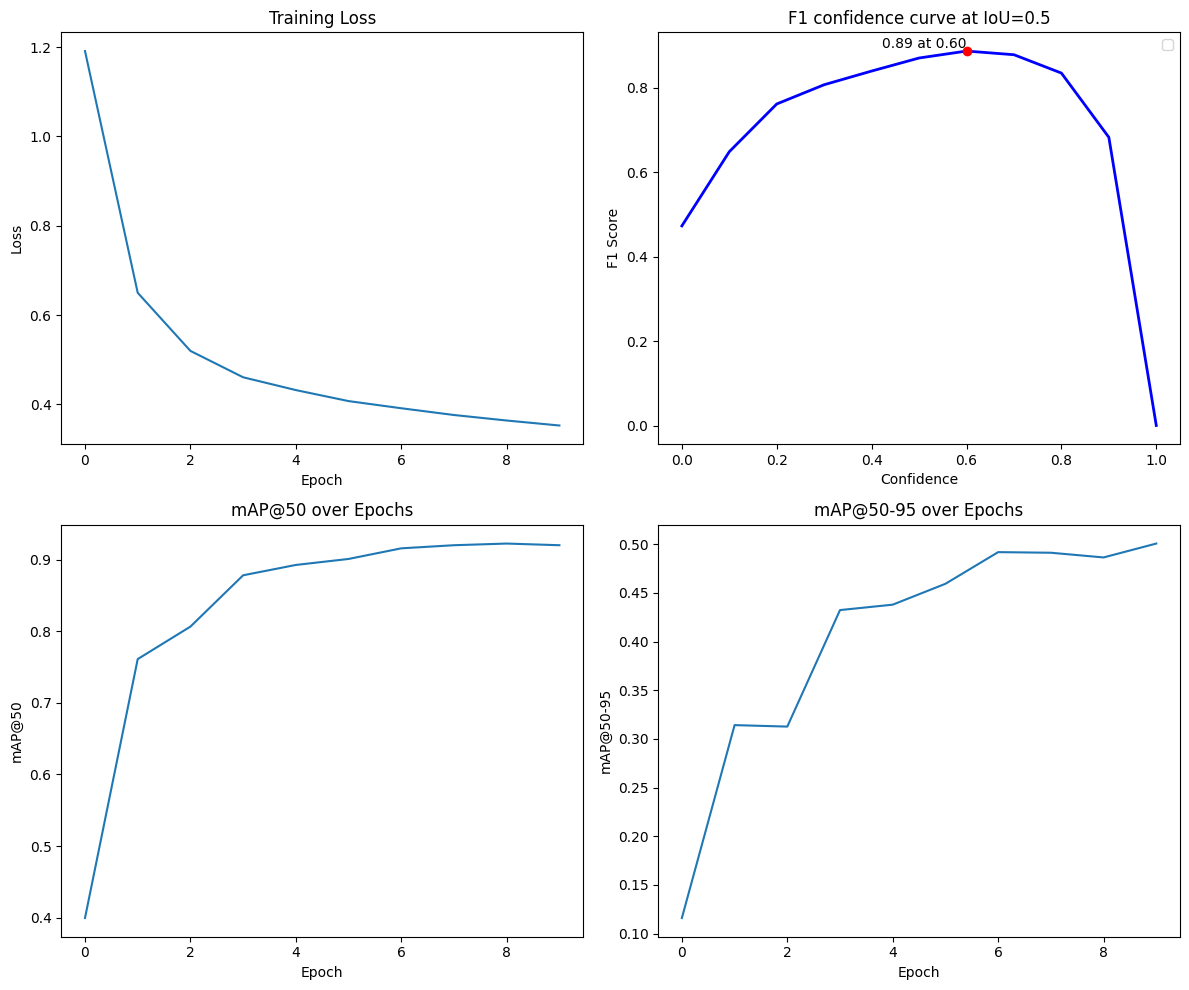

In [ ]:
history, conf_thresholds, f1_scores, best_conf, best_f1 = training_validation(get_retinanet_model, "RetinaNet (not pretrained)", False, val_loader)
plot_history(history, conf_thresholds, f1_scores, best_conf, best_f1)

## YOLO

In [ ]:
def convert_voc_to_yolo(xml_file, labels_dir, image_dir):
    """Converts XML files to YOLO txt format annotations"""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(image_dir, filename)

    size_tag = root.find('size')
    img_width = int(size_tag.find('width').text)
    img_height = int(size_tag.find('height').text)

    base_name = os.path.splitext(filename)[0]
    txt_file = os.path.join(labels_dir, base_name + '.txt')

    lines = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_id = 0

        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        x_center = ((xmin + xmax) / 2.0) / img_width
        y_center = ((ymin + ymax) / 2.0) / img_height
        w = (xmax - xmin) / img_width
        h = (ymax - ymin) / img_height

        line = f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}"
        lines.append(line)

    with open(txt_file, 'w') as f:
        for line in lines:
            f.write(line + '\n')

def prepare_dataset(data_dir, train_split=0.8):
    """Prepare dataset for training, creating folders for training and validation, along with .yaml file"""
    images_dir = os.path.join(data_dir, "JEPG")
    annotations_dir = os.path.join(data_dir, "anntations")

    output_images_train = os.path.join(data_dir, "images", "train")
    output_images_val = os.path.join(data_dir, "images", "val")
    output_labels_train = os.path.join(data_dir, "labels", "train")
    output_labels_val = os.path.join(data_dir, "labels", "val")

    os.makedirs(output_images_train, exist_ok=True)
    os.makedirs(output_images_val, exist_ok=True)
    os.makedirs(output_labels_train, exist_ok=True)
    os.makedirs(output_labels_val, exist_ok=True)

    xml_files = glob.glob(os.path.join(annotations_dir, "*.xml"))

    random.shuffle(xml_files)
    train_count = int(len(xml_files) * train_split)
    train_xmls = xml_files[:train_count]
    val_xmls = xml_files[train_count:]

    def move_and_convert(xml_list, images_subdir, labels_subdir):
        for xml_file in xml_list:
            if xml_file.endswith("103064.xml") or xml_file.endswith("1050431.xml"):
                continue

            convert_voc_to_yolo(xml_file, labels_subdir, images_dir)

            tree = ET.parse(xml_file)
            root = tree.getroot()
            filename = root.find('filename').text
            src_img_path = os.path.join(images_dir, filename)
            dst_img_path = os.path.join(images_subdir, filename)
            if os.path.exists(src_img_path):
                shutil.copy2(src_img_path, dst_img_path)

    move_and_convert(train_xmls, output_images_train, output_labels_train)
    move_and_convert(val_xmls, output_images_val, output_labels_val)

    data_yaml = os.path.join(data_dir, "data.yaml")
    with open(data_yaml, 'w') as f:
        f.write("train: {}/images/train\n".format(data_dir))
        f.write("val: {}/images/val\n".format(data_dir))
        f.write("names: ['chromosomes']\n")

def train_yolo(data_dir, model_size, epochs, imgsz=640):
    """Training fucntion for YOLO"""
    data_yaml = os.path.join(data_dir, "data.yaml")
    model_name = f"yolov8{model_size}.pt"
    model = YOLO(model_name)

    model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        project=os.path.join(data_dir, "runs"),
        name=f"yolo_chromosomes_{model_size}",
        exist_ok=True,
        pretrained=False
    )
    return model


DATA_DIR = "/content/single_chromosomes_object"
prepare_dataset(DATA_DIR, train_split=0.8)

model = train_yolo(
    data_dir=DATA_DIR,
    model_size='m',
    epochs=30,
    imgsz=640
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 103MB/s] 


Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/single_chromosomes_object/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/single_chromosomes_object/runs, name=yolo_chromosomes_m, exist_ok=True, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

100%|██████████| 755k/755k [00:00<00:00, 41.4MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

 18                  -1  2   1846272  ultralytics.nn.modules.block.C2f             [576, 384, 2]                 
 19                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3776275  ultralytics.nn.modules.head.Detect           [1, [192, 384, 576]]          
Model summary: 169 layers, 25,856,899 parameters, 25,856,883 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 165MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2284.5±607.3 MB/s, size: 90.9 KB)


train: Scanning /content/single_chromosomes_object/labels/train... 1598 images, 0 backgrounds, 2 corrupt: 100%|██████████| 1598/1598 [00:01<00:00, 910.52it/s]

train: /content/single_chromosomes_object/images/train/104241.jpg: corrupt JPEG restored and saved
train: /content/single_chromosomes_object/images/train/1050861.jpg: corrupt JPEG restored and saved
train: /content/single_chromosomes_object/images/train/1050922.jpg: corrupt JPEG restored and saved
train: /content/single_chromosomes_object/images/train/1051004.jpg: corrupt JPEG restored and saved
train: /content/single_chromosomes_object/images/train/1051162.jpg: corrupt JPEG restored and saved
train: /content/single_chromosomes_object/images/train/1052052.jpg: corrupt JPEG restored and saved
train: /content/single_chromosomes_object/images/train/1052224.jpg: corrupt JPEG restored and saved
train: /content/single_chromosomes_object/images/train/1052481.jpg: corrupt JPEG restored and saved
train: /content/single_chromosomes_object/images/train/1052651.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0015      1.0011]
train: /content/single_chromosome

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 713.7±133.5 MB/s, size: 103.0 KB)


val: Scanning /content/single_chromosomes_object/labels/val... 400 images, 0 backgrounds, 1 corrupt: 100%|██████████| 400/400 [00:00<00:00, 750.71it/s]

val: /content/single_chromosomes_object/images/val/1051072.jpg: corrupt JPEG restored and saved
val: /content/single_chromosomes_object/images/val/1051851.jpg: corrupt JPEG restored and saved
val: /content/single_chromosomes_object/images/val/1052872.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0018      1.0019]
val: /content/single_chromosomes_object/images/val/1055131.jpg: corrupt JPEG restored and saved
val: New cache created: /content/single_chromosomes_object/labels/val.cache


Plotting labels to /content/single_chromosomes_object/runs/yolo_chromosomes_m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/single_chromosomes_object/runs/yolo_chromosomes_m
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.18G      1.214     0.9242      1.103        969        640: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]

                   all        399      18388      0.761      0.692      0.716       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.04G      1.159     0.6135      1.073        653        640: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        399      18388      0.847      0.899      0.873        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.32G      1.156     0.6008      1.075        750        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        399      18388      0.941      0.948      0.972      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.13G      1.129     0.5918      1.066        870        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]

                   all        399      18388      0.879      0.789      0.884      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.12G      1.116     0.5665      1.058        854        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


                   all        399      18388      0.915      0.869      0.935      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.77G      1.106     0.5563       1.06        992        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.22it/s]

                   all        399      18388      0.955      0.952       0.98      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.17G      1.075     0.5382      1.042        899        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


                   all        399      18388      0.959      0.954      0.982      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.78G      1.075     0.5319      1.044        994        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        399      18388      0.951      0.908      0.959      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.86G      1.067     0.5196      1.039        943        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.28it/s]

                   all        399      18388      0.974      0.971      0.985      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       8.1G       1.06     0.5227      1.037        883        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        399      18388      0.964       0.96      0.978      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.79G       1.07     0.5179       1.04        884        640: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


                   all        399      18388      0.942       0.86      0.931      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.09G      1.053     0.5065      1.032        969        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


                   all        399      18388      0.959      0.946      0.977      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.66G      1.044     0.4963      1.026        874        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]

                   all        399      18388      0.966      0.956      0.983      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.88G      1.038     0.4966      1.027       1063        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

                   all        399      18388      0.969      0.963      0.984      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.48G      1.032     0.4898      1.022        720        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


                   all        399      18388      0.947      0.885      0.947      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.84G      1.026      0.485      1.018        821        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]

                   all        399      18388      0.975      0.974      0.987      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       8.2G      1.018     0.4789      1.016        948        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


                   all        399      18388      0.979      0.975      0.987      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.08G      1.013     0.4766      1.016        604        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]

                   all        399      18388       0.98      0.972      0.988      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.59G      1.008     0.4704      1.014        627        640: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]

                   all        399      18388       0.98      0.976      0.988      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.08G      1.001     0.4648      1.014       1202        640: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

                   all        399      18388      0.978      0.973      0.987      0.733


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.33G     0.9818     0.4233      1.023        533        640: 100%|██████████| 100/100 [00:53<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        399      18388       0.97      0.964      0.985       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.34G     0.9812     0.4221       1.02        540        640: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


                   all        399      18388      0.982      0.976      0.989      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.33G     0.9823      0.422      1.024        535        640: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]

                   all        399      18388      0.971      0.967      0.986      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.33G     0.9737     0.4159      1.024        522        640: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


                   all        399      18388      0.977      0.974      0.988      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.34G     0.9658      0.406       1.01        547        640: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


                   all        399      18388      0.982      0.977      0.988      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.33G     0.9615     0.4026      1.014        542        640: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


                   all        399      18388      0.982      0.977      0.988      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.35G     0.9554     0.4008      1.012        543        640: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


                   all        399      18388      0.981      0.978      0.989      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.34G      0.942     0.3902      1.008        541        640: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]

                   all        399      18388      0.982      0.978      0.988      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.33G     0.9341     0.3852      1.001        532        640: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


                   all        399      18388       0.98       0.98      0.988      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.35G     0.9282     0.3808     0.9962        556        640: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


                   all        399      18388      0.983      0.978      0.989      0.747

30 epochs completed in 0.512 hours.
Optimizer stripped from /content/single_chromosomes_object/runs/yolo_chromosomes_m/weights/last.pt, 52.0MB
Optimizer stripped from /content/single_chromosomes_object/runs/yolo_chromosomes_m/weights/best.pt, 52.0MB

Validating /content/single_chromosomes_object/runs/yolo_chromosomes_m/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


                   all        399      18388      0.983      0.978      0.989      0.747
Speed: 0.2ms preprocess, 9.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/single_chromosomes_object/runs/yolo_chromosomes_m


In [ ]:
results = model.val(data=os.path.join(DATA_DIR, "data.yaml"))

map50 = float(results.box.map50)
map75 = float(results.box.map75)
map5095 = float(results.box.map)

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2484.5±711.2 MB/s, size: 109.3 KB)


val: Scanning /content/single_chromosomes_object/labels/val.cache... 400 images, 0 backgrounds, 1 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]

val: /content/single_chromosomes_object/images/val/1051072.jpg: corrupt JPEG restored and saved
val: /content/single_chromosomes_object/images/val/1051851.jpg: corrupt JPEG restored and saved
val: /content/single_chromosomes_object/images/val/1052872.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0018      1.0019]
val: /content/single_chromosomes_object/images/val/1055131.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]


                   all        399      18388      0.983      0.978      0.989      0.748
Speed: 0.5ms preprocess, 21.0ms inference, 0.0ms loss, 12.5ms postprocess per image
Results saved to runs/detect/val


In [ ]:
print(f"YOLOv8 results: mAP@50 = {map50:.4f}, mAP@75 = {map75:.4f}, mAP@50–95 = {map5095:.4f}")

YOLOv8 results: mAP@50 = 0.9886, mAP@75 = 0.8903, mAP@50–95 = 0.7479



image 1/1 /content/single_chromosomes_object/JEPG/103071.jpg: 640x608 47 chromosomess, 37.5ms
Speed: 3.0ms preprocess, 37.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


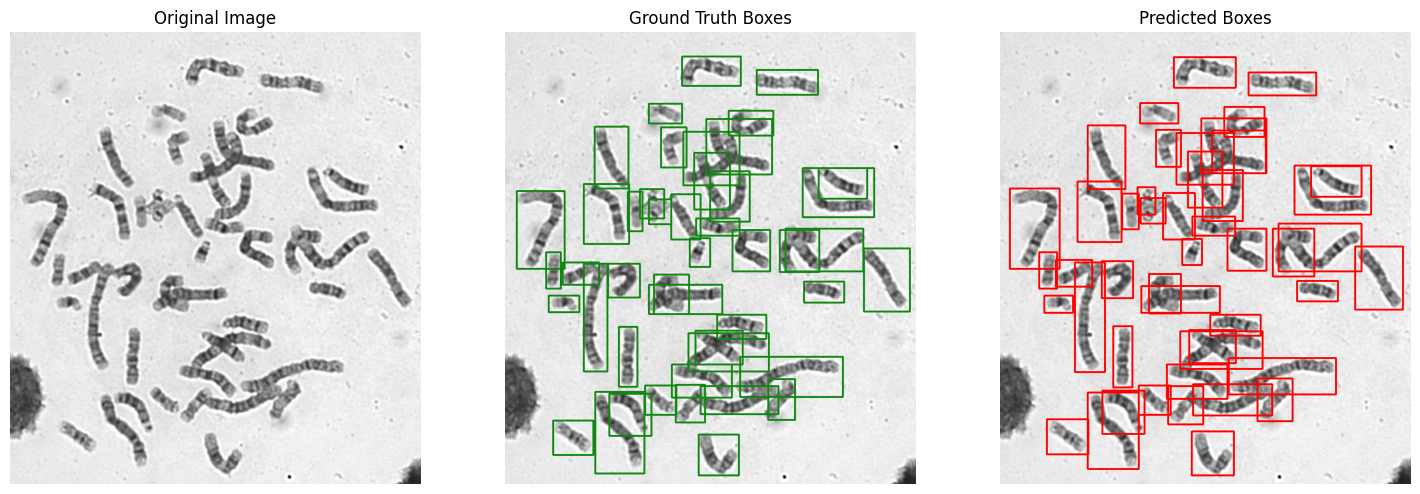

In [ ]:
image_path  = "/content/single_chromosomes_object/JEPG/103071.jpg"
labels_path = "/content/single_chromosomes_object/anntations/103071.xml"
model_path  = "/content/single_chromosomes_object/runs/yolo_chromosomes_m/weights/best.pt"

def parse_voc_annotations(xml_file):
    """Parses XML annotations"""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bboxes = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        bboxes.append([xmin, ymin, xmax, ymax])
    return bboxes

def draw_boxes(image, bboxes, color, thickness=2):
    """Draw boxes for inference check"""
    for (xmin, ymin, xmax, ymax) in bboxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)

original_img = cv2.imread(image_path)

original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

gt_bboxes = parse_voc_annotations(labels_path)

gt_img = original_img.copy()
draw_boxes(gt_img, gt_bboxes, (17, 135, 15))
gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

model = YOLO(model_path)
results = model(image_path)

pred_img = original_img.copy()

for r in results:
    for box in r.boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        cv2.rectangle(pred_img, (x1, y1), (x2, y2), (0,0,255), 2)

pred_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(original_rgb)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(gt_rgb)
axs[1].set_title("Ground Truth Boxes")
axs[1].axis('off')

axs[2].imshow(pred_rgb)
axs[2].set_title("Predicted Boxes")
axs[2].axis('off')

plt.tight_layout()
plt.show()